In [ ]:
# !pip install -q scikit-learn beir

In [ ]:
! pip install -q -e ../..


In [3]:
# Import groundedness feedback function
from benchmark_frameworks.eval_as_recommendation import compute_ece
from benchmark_frameworks.eval_as_recommendation import score_passages
from test_cases import generate_ms_marco_context_relevance_benchmark
from benchmark_frameworks.eval_as_recommendation import score_passages, compute_mrr, compute_ece, compute_hit_rate, run_benchmark_with_temp_scaling
Tru().reset_database()




🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `Tru` to prevent this.


In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "sk-..."
os.environ["SNOWFLAKE_ACCOUNT"] = "xxx-xxx" # xxx-xxx.snowflakecomputing.com
os.environ["SNOWFLAKE_USER"] = "xxx" 
os.environ["SNOWFLAKE_USER_PASSWORD"] = "xxx"
os.environ["SNOWFLAKE_DATABASE"] = "xxx"
os.environ["SNOWFLAKE_SCHEMA"] = "xxx"
os.environ["SNOWFLAKE_WAREHOUSE"] = "xxx"


In [6]:
from trulens_eval.keys import check_keys
check_keys("SNOWFLAKE_ACCOUNT", "SNOWFLAKE_USER", "SNOWFLAKE_USER_PASSWORD")
from snowflake.snowpark import Session

connection_params = {
    "account": os.environ["SNOWFLAKE_ACCOUNT"],
    "user": os.environ["SNOWFLAKE_USER"],
    "password": os.environ["SNOWFLAKE_USER_PASSWORD"],
}


# Create a Snowflake session
snowflake_session = Session.builder.configs(connection_params).create()

✅ Key SNOWFLAKE_ACCOUNT set from environment.
✅ Key SNOWFLAKE_USER set from environment.
✅ Key SNOWFLAKE_USER_PASSWORD set from environment.


### Set up initial model providers as evaluators for meta evaluation

We will start with GPT-4o as the benchmark

In [7]:
from trulens_eval.feedback import OpenAI, Cortex
gpt4o = OpenAI(model_engine="gpt-4o")
mistral = Cortex(model_engine="mistral-large")

In [8]:
gpt4o.context_relevance_with_cot_reasons('who is the guy calling?', 'some guy calling saying his name is Danny')

(1.0,
 {'reason': 'Criteria: CONTEXT that is RELEVANT to the entirety of the QUESTION should get a score of 3, which is the full mark.\nSupporting Evidence: The CONTEXT directly answers the QUESTION by providing the name of the person calling, which is Danny. This information is entirely relevant and sufficient to answer the QUESTION fully.'})

In [9]:
score, confidence = gpt4o.context_relevance_verb_confidence('who is steve jobs', 'apple founder is steve jobs')
print(f"score: {score}, confidence: {confidence}")

score: 1.0, confidence: 1.0


In [10]:
score, confidence  = mistral.context_relevance_verb_confidence('who is the guy calling?', 'some guy calling saying his name is Danny', temperature=0.5)
print(f"score: {score}, confidence: {confidence}")

score: 1.0, confidence: 1.0


In [11]:
benchmark_data = []
for i in range(1, 6):
    dataset_path=f"./datasets/ms_marco/ms_marco_train_v2.1_{i}.json"
    benchmark_data.extend(
        list(generate_ms_marco_context_relevance_benchmark(dataset_path))
    )

In [12]:
import pandas as pd

df = pd.DataFrame(benchmark_data)

print(df.count())

query_id        3042
query           3042
passage         3042
is_selected     3042
relevant_idx    3042
dtype: int64


In [13]:
df.head()

,query_id,query,passage,is_selected,relevant_idx
0,1185869,)what was the immediate impact of the success ...,The presence of communication amid scientific ...,1,0
1,1185869,)what was the immediate impact of the success ...,The Manhattan Project and its atomic bomb help...,0,0
2,1185869,)what was the immediate impact of the success ...,Essay on The Manhattan Project - The Manhattan...,0,0
3,1185869,)what was the immediate impact of the success ...,The Manhattan Project was the name for a proje...,0,0
4,1185869,)what was the immediate impact of the success ...,versions of each volume as well as complementa...,0,0


### Temperature Scaling 

In [14]:


temperatures = [0, 0.3, 0.7, 1]


def wrapped_relevance_gpt4o(input, output, temperature):
    return gpt4o.context_relevance_verb_confidence(question=input, context=output, temperature=temperature)

def wrapped_relevance_mistral(input, output, temperature):
    return mistral.context_relevance_verb_confidence(question=input, context=output, temperature=temperature)



feedback_functions = {
    'gpt-4o': wrapped_relevance_gpt4o,
    'mistral-large': wrapped_relevance_mistral,
}

backoffs_by_functions = {
    'gpt-4o': 0,
    'mistral-large': 0,
}

In [16]:
import concurrent.futures
# Parallelizing temperature scaling
k = 1 #  MS MARCO specific
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(run_benchmark_with_temp_scaling, df, feedback_functions, temp, k, backoffs_by_functions) for temp in temperatures]
    for future in concurrent.futures.as_completed(futures):
        future.result()

Relevance scores by query id: defaultdict(<class 'list'>, {1185869: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333], 1185868: [0.6666666666666666, 1.0, 1.0, 0.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0], 1185854: [0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.3333333333333333, 0.0, 1.0, 0.6666666666666666], 1185755: [0.0, 0.0, 0.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.0, 0.0, 0.0], 1184773: [0.6666666666666666, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], 467556: [0.6666666666666666, 1.0, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.0, 0.3333333333333333], 28213: [0.3333333333333333, 0.3333333333333333, 0.0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 44588: [0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0], 410717: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333

### Visualization of calibration


In [72]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_reliability_diagram(csv_file, temperature, ece_value, brier_score):
    data = pd.read_csv(csv_file, header=None, names=["query_id", "relevance_score", "confidence_score", "true_label"])

    # Compute calibration curve
    true_pred = ((data['relevance_score'] >= 0.5).astype(int) == data['true_label']).astype(int)


    prob_true, prob_pred = calibration_curve(true_pred, data["confidence_score"], n_bins=5)

    # Plot reliability diagram
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label=f'Temperature {temperature}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')

    # Display ECE value
    plt.text(0.6, 0.2, f"ECE: {ece_value:.4f}", bbox=dict(facecolor='white', alpha=0.5))
    plt.text(0.6, 0.1, f"Brier score: {brier_score:.4f}", bbox=dict(facecolor='white', alpha=0.5))
    # Labels and title
    plt.xlabel('Confidence bins')
    plt.ylabel('Accuracy bins')
    plt.title(f'Reliability Diagram for GPT-4o with t={temperature}')
    plt.legend()

In [73]:
csv_file = "results/gpt-4o-t_0-benchmark_eval_results.csv"
ece = 0.25978426229508195
brier_score = 0.23403157255616272

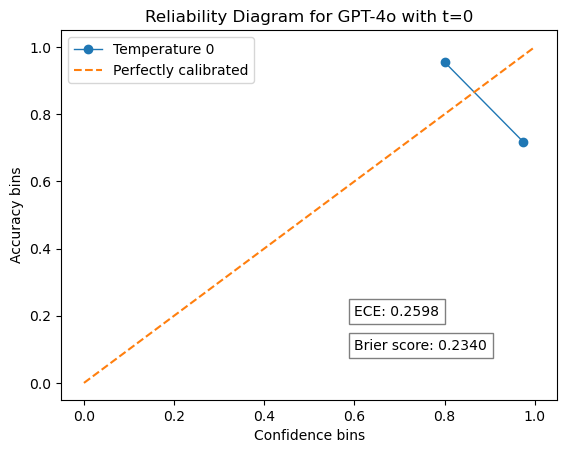

In [74]:
plot_reliability_diagram(csv_file, 0, ece, brier_score)


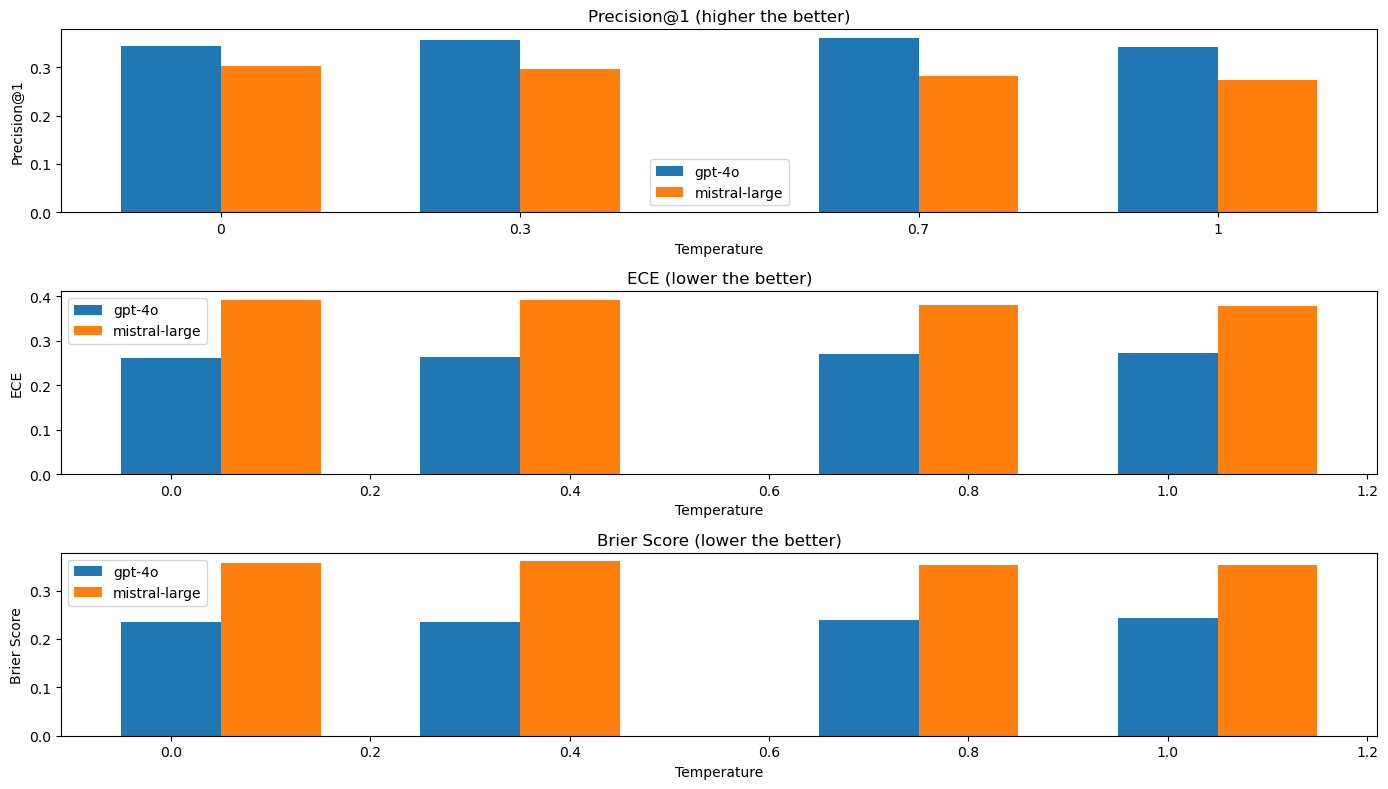

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# List of temperatures and corresponding CSV files
temperatures = [0, 0.3, 0.7, 1]
csv_files = ['consolidated_results_verbalized_ece_t_0.csv', 'consolidated_results_verbalized_ece_t_0.3.csv', 'consolidated_results_verbalized_ece_t_0.7.csv', 'consolidated_results_verbalized_ece_t_1.csv']

# Load and combine data
data = []
for temp, csv_file in zip(temperatures, csv_files):
    df = pd.read_csv(csv_file)
    df['Temperature'] = temp
    data.append(df)

combined_data = pd.concat(data)

# Plotting
plt.figure(figsize=(14, 8))
bar_width = 0.1

# Plot Precision@1
plt.subplot(3, 1, 1)
for i, function_name in enumerate(combined_data['Function Name'].unique()):
    subset = combined_data[combined_data['Function Name'] == function_name]
    plt.bar([t + i * bar_width for t in temperatures], subset['Precision@1'], width=bar_width, label=function_name)
plt.title('Precision@1 (higher the better)')
plt.xlabel('Temperature')
plt.ylabel('Precision@1')
plt.xticks([t + bar_width * (len(combined_data['Function Name'].unique()) - 1) / 2 for t in temperatures], temperatures)
plt.legend()

# Plot ECE
plt.subplot(3, 1, 2)
for i, function_name in enumerate(combined_data['Function Name'].unique()):
    subset = combined_data[combined_data['Function Name'] == function_name]
    plt.bar([t + i * bar_width for t in temperatures], subset['ECE'], width=bar_width, label=function_name)
plt.title('ECE (lower the better)')
plt.xlabel('Temperature')
plt.ylabel('ECE')
plt.legend()

# Plot Brier Score
plt.subplot(3, 1, 3)
for i, function_name in enumerate(combined_data['Function Name'].unique()):
    subset = combined_data[combined_data['Function Name'] == function_name]
    plt.bar([t + i * bar_width for t in temperatures], subset['Brier Score'], width=bar_width, label=function_name)
plt.title('Brier Score (lower the better)')
plt.xlabel('Temperature')
plt.ylabel('Brier Score')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
temperatures = [0, 0.3, 0.7, 1]
csv_files = ['consolidated_results_verbalized_ece_t_0.csv', 'consolidated_results_verbalized_ece_t_0.3.csv', 'consolidated_results_verbalized_ece_t_0.7.csv', 'consolidated_results_verbalized_ece_t_1.csv']

In [25]:
# Load and combine data
data = []
for temp, csv_file in zip(temperatures, csv_files):
    df = pd.read_csv(csv_file)
    df['Temperature'] = temp
    data.append(df)

combined_data = pd.concat(data)

In [26]:
combined_data.groupby(['Function Name', 'Temperature']).mean()

Precision@1       ECE  Brier Score
Function Name Temperature                                    
gpt-4o        0.0             0.344487  0.259784     0.234032
              0.3             0.355807  0.263555     0.235443
              0.7             0.360109  0.269874     0.239077
              1.0             0.340723  0.272522     0.242560
mistral-large 0.0             0.301788  0.391543     0.357940
              0.3             0.295176  0.391903     0.360261
              0.7             0.282332  0.380414     0.351877
              1.0             0.273315  0.378251     0.352311